# Global Freedom Forecasting and Synthetic Regime Simulation Using GANs

This project explores global patterns in political freedom using the Freedom in the World dataset (2013–2025). We apply supervised machine learning to forecast country-level freedom status and scores based on political and civil liberty indicators. To address class imbalance and simulate underrepresented political conditions, we employ Auxiliary Classifier GANs (AC-GANs) to generate realistic synthetic regime profiles. This dual approach enables both accurate forecasting and exploratory scenario modeling—helping us understand not only where freedom is going, but also what alternate political realities might look like.

## Step 1: Loading and Cleaning the Dataset to prepare for Exploration and Visualization

In [40]:
import pandas as pd
# Use a raw string (r"") to avoid issues with backslashes
file_path = r"C:\Users\Admin\Desktop\Milano-BIcocca\Semester 2\Data Science Lab\All_data_FIW_2013-2024 (1).xlsx"

In [42]:
# Load the dataset from the correct sheet
raw_df = pd.read_excel(file_path, sheet_name="FIW13-25", skiprows=0)

In [43]:
raw_df.head()

,Freedom in the World 2013-2025 Raw Data,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40,Unnamed: 41,Unnamed: 42,Unnamed: 43
0,Country/Territory,Region,C/T,Edition,Status,PR rating,CL rating,A1,A2,A3,...,F3,F4,F,G1,G2,G3,G4,G,CL,Total
1,Abkhazia,Eurasia,t,2025,PF,5,5,2,2,1,...,1,1,4,1,1,2,1,5,22,39
2,Afghanistan,Asia,c,2025,NF,7,7,0,0,0,...,0,0,0,0,1,0,1,2,5,6
3,Albania,Europe,c,2025,PF,3,3,3,3,3,...,2,3,10,3,2,2,2,9,40,68
4,Algeria,Africa,c,2025,NF,6,5,1,1,1,...,2,2,6,2,2,2,1,7,21,31


In [44]:
# Extract actual headers from row 1 (index 0)
new_header = raw_df.iloc[0]
df = raw_df[1:].copy()
df.columns = new_header
df = df.reset_index(drop=True)

In [45]:
# Review actual column names before renaming anything
print("Column names from the file:\n")
print(df.columns.tolist())

Column names from the file:

['Country/Territory', 'Region', 'C/T', 'Edition', 'Status', 'PR rating', 'CL rating', 'A1', 'A2', 'A3', 'A', 'B1', 'B2', 'B3', 'B4', 'B', 'C1', 'C2', 'C3', 'C', 'Add Q', 'Add A', 'PR', 'D1', 'D2', 'D3', 'D4', 'D', 'E1', 'E2', 'E3', 'E', 'F1', 'F2', 'F3', 'F4', 'F', 'G1', 'G2', 'G3', 'G4', 'G', 'CL', 'Total']


In [58]:
# Rename columns safely before accessing them
df = df.rename(columns={
    'Edition': 'Year',
    'Status': 'FreedomStatus',
    'Total': 'TotalScore'  # <-- we renamed 'Total' to 'TotalScore'
})

In [60]:
# STEP 3: Convert important numeric score columns to numbers
numeric_cols = [
    'Year', 'PR rating', 'CL rating',
    'A', 'B', 'C', 'D', 'E', 'F', 'G',
    'PR', 'CL', 'TotalScore'
]
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

In [62]:
# STEP 4: Drop rows missing important scores or class label
df_cleaned = df.dropna(subset=numeric_cols + ['FreedomStatus'])

In [64]:
# STEP 5: Preview the cleaned data
df_cleaned[['Country/Territory', 'Year', 'FreedomStatus', 'TotalScore'] + numeric_cols].head()

,Country/Territory,Year,FreedomStatus,TotalScore,Year,PR rating,CL rating,A,B,C,D,E,F,G,PR,CL,TotalScore
0,Abkhazia,2025,PF,39,2025,5,5,5,8,4,8,5,4,5,17,22,39
1,Afghanistan,2025,NF,6,2025,7,7,0,0,1,0,3,0,2,1,5,6
2,Albania,2025,PF,68,2025,3,3,9,12,7,13,8,10,9,28,40,68
3,Algeria,2025,NF,31,2025,6,5,3,4,3,5,3,6,7,10,21,31
4,Andorra,2025,F,93,2025,1,1,12,15,11,14,11,15,15,38,55,93


## STEP 2: Exploratory Data Analysis (EDA)

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use seaborn whitegrid style
sns.set(style="whitegrid")

C:\Users\Admin\AppData\Local\Temp\ipykernel_19188\1479351031.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_cleaned, x='FreedomStatus', order=['F', 'PF', 'NF'], palette='viridis')


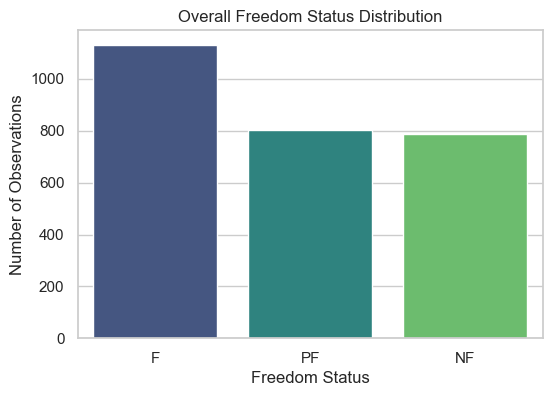

In [73]:
# 1. Freedom status distribution (overall)
plt.figure(figsize=(6, 4))
sns.countplot(data=df_cleaned, x='FreedomStatus', order=['F', 'PF', 'NF'], palette='viridis')
plt.title("Overall Freedom Status Distribution")
plt.xlabel("Freedom Status")
plt.ylabel("Number of Observations")
plt.show()

This bar chart displays the total number of observations for each Freedom Status category: "Free" (F), "Partly Free" (PF), and "Not Free" (NF). It shows that the largest share of the data points belongs to the "Free" category, followed by "Partly Free" and then "Not Free." This suggests that, across the recorded years and countries, most instances reflect relatively higher freedom. However, the difference between the three categories is not extreme, indicating a balanced representation and room for analyzing shifting patterns in global freedom levels.

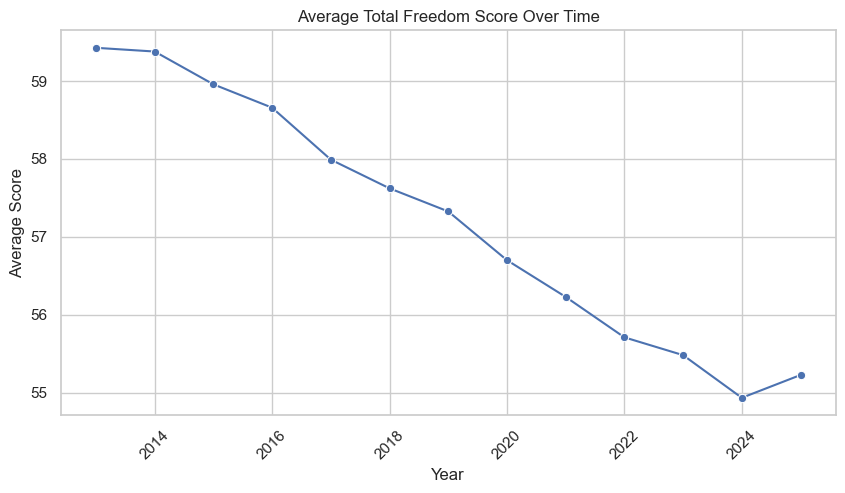

In [75]:
# 2. Average Total Score by Year
avg_score_by_year = df_cleaned.groupby('Year')['TotalScore'].mean().reset_index()
plt.figure(figsize=(10, 5))
sns.lineplot(data=avg_score_by_year, x='Year', y='TotalScore', marker='o')
plt.title("Average Total Freedom Score Over Time")
plt.ylabel("Average Score")
plt.xlabel("Year")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

This line chart shows the average Total Freedom Score across all countries for each year from 2013 to 2025. A noticeable downward trend is observed, indicating a global decline in freedom over time. The decline is gradual but steady, suggesting that civil liberties and political rights have been deteriorating in many parts of the world. This trend highlights the importance of monitoring and addressing systemic threats to freedom.

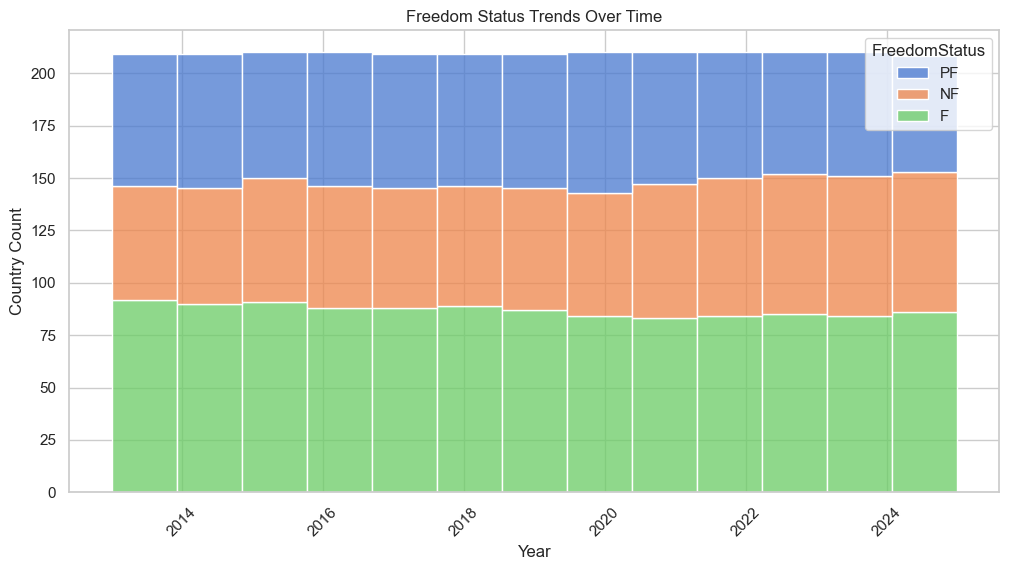

In [77]:
# 3. Freedom status stacked per year
plt.figure(figsize=(12, 6))
sns.histplot(data=df_cleaned, x='Year', hue='FreedomStatus', multiple='stack', palette='muted', bins=len(df_cleaned['Year'].unique()))
plt.title("Freedom Status Trends Over Time")
plt.xlabel("Year")
plt.ylabel("Country Count")
plt.xticks(rotation=45)
plt.show()

This stacked bar chart displays how many countries fell into each Freedom Status category (F, PF, NF) year by year. While the "Free" status consistently has the highest count, the proportions of "Partly Free" and "Not Free" have either remained stable or slightly increased over the years. This visualization reveals how the global distribution of freedom status has evolved, indicating not only a drop in total freedom but also a slow erosion in the number of fully free nations.

C:\Users\Admin\AppData\Local\Temp\ipykernel_19188\617126560.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=region_scores, x='Region', y='TotalScore', palette='coolwarm')


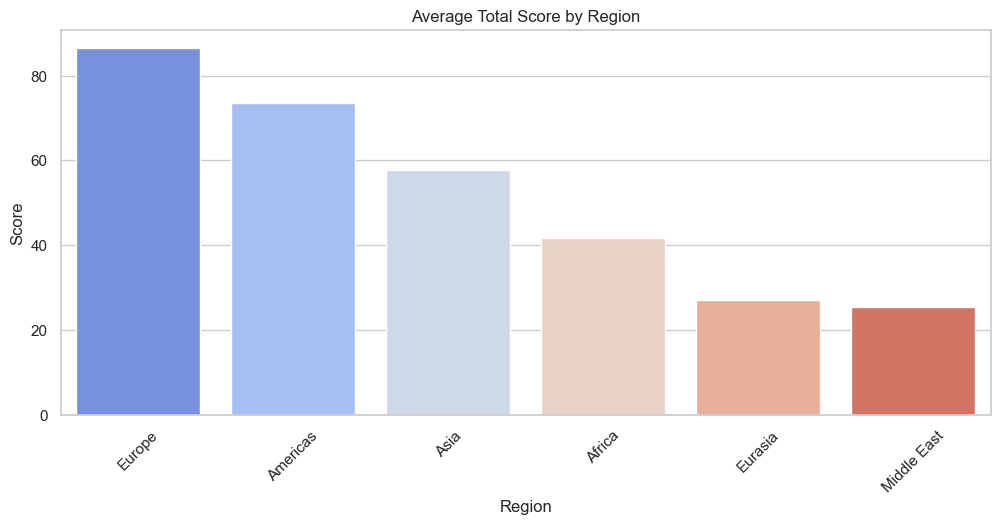

In [79]:
# 4. Average Total Score by Region
region_scores = df_cleaned.groupby('Region')['TotalScore'].mean().sort_values(ascending=False).reset_index()
plt.figure(figsize=(12, 5))
sns.barplot(data=region_scores, x='Region', y='TotalScore', palette='coolwarm')
plt.title("Average Total Score by Region")
plt.xticks(rotation=45)
plt.ylabel("Score")
plt.xlabel("Region")
plt.show()

This bar chart compares the average Total Freedom Score across major world regions. Europe stands out with the highest average score, followed by the Americas. Asia, Africa, and particularly the Middle East and Eurasia show significantly lower average scores. This regional disparity illustrates how geopolitical, historical, and cultural factors contribute to different levels of freedom, reinforcing the need for region-specific analysis and intervention strategies.



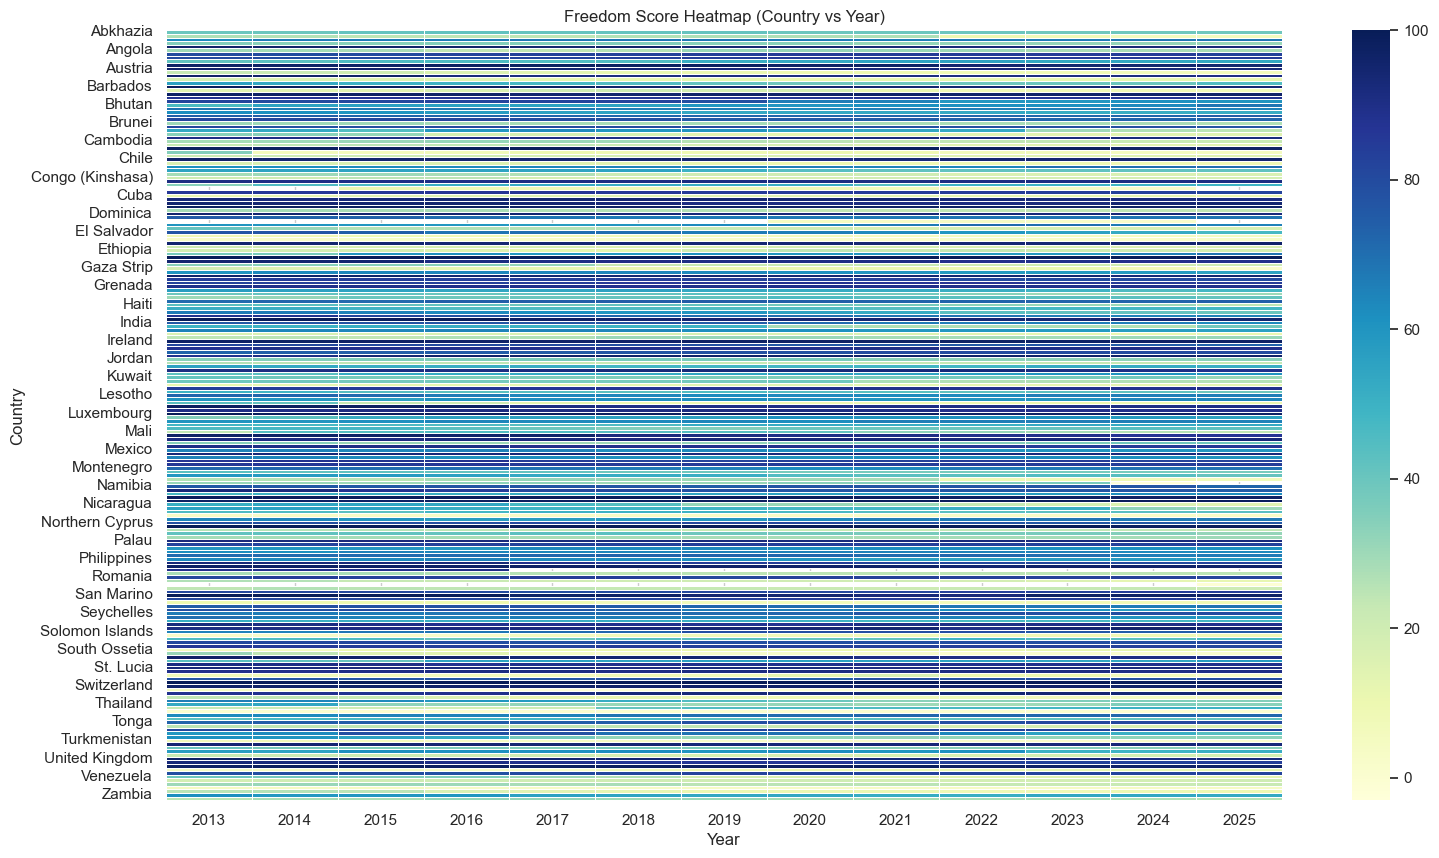

In [88]:
# 5. Heatmap: Country vs Year for TotalScore
heatmap_data = df_cleaned.pivot_table(index='Country/Territory', columns='Year', values='TotalScore')
plt.figure(figsize=(18, 10))
sns.heatmap(heatmap_data, cmap='YlGnBu', linewidths=0.5)
plt.title("Freedom Score Heatmap (Country vs Year)")
plt.xlabel("Year")
plt.ylabel("Country")
plt.show()

The heatmap offers a country-by-year view of freedom scores. Each row represents a country, and each column represents a year. The intensity of the color reflects the Total Freedom Score: darker shades indicate higher freedom, while lighter shades suggest reduced freedom. This visualization helps identify countries with consistently high or low scores, as well as those experiencing significant changes. It also highlights missing data where no scores were reported, which may coincide with conflict, lack of access, or political suppression.